In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import logging
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    # filename='app.log'
)

In [3]:
import yaml
from base64 import b64encode

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
        return yaml.dump(yaml_content, default_flow_style=False)

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return b64encode(image_file.read()).decode('utf-8')

app_strings = read_yaml_file('save_puppy.yaml')
screenshot = encode_image('save_puppy.png')

In [4]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import operator
import os
from langchain_openai import ChatOpenAI

class State(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]
  contextualized: str
  translation: str
  advice: str

llm = ChatOpenAI(
  api_key=os.getenv("OPENAI_API_KEY"),
  model="gpt-4o"
)

In [5]:
def contextualize(state):
  logging.info("contextualizing")
  prompt = """You are an expert in mobile app string localization and internationalization.
  You are preparing app strings to be localized in another language by 
  providing additional context in English to help the translator. 
  Add comments to each line of the following text based on what you see in the image. 
  Use YAML style comments and put them on the line above the text being commented."""
  user = HumanMessage(content=[
    {"type": "text", "text": prompt},
    {"type": "text", "text": app_strings},
    {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/png;base64,{screenshot}"
      }
    }
  ])
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response], "contextualized": response.content}

In [6]:
def translate(state):
  logging.info("translating")
  given_text = state["contextualized"]
  prompt = f"""You are a world-class translator. Translate the given text from English to Spanish. 
  Each line is commented and you should take those comments into consideration in order 
  to get an accurate translation. Don't translate the comments or the keys.
  Given text: 
  {given_text}
  """
  user = HumanMessage(content=prompt)
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response], "translation": response.content}

In [7]:
def check(state):
  logging.info("checking")
  translation = state["translation"]
  prompt = f"""You are an expert in mobile app UI/UX and also cross-cultural communication.
  A translator has submitted a translation for the strings of a UI layout.
  Check the translation for accuracy. If the translation is good, reply with one 
  word: "good". However, if there is anything that is ambiguous or might be translated wrong, 
  reply with a paragraph expressing your concern.
  {app_strings}
  Here is the translation with contextual comments:
  {translation}
  """
  user = HumanMessage(content=prompt)
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response], "advice": response.content}

In [8]:
def translation_good(state):
  advice = state["advice"]
  logging.info(f"translation: \n{state["translation"]}\n")
  logging.info(f"advice: {advice}")
  if advice == "good":
    return "good"
  else:
    return "problem"

In [9]:
def human_review(state):
  return state

In [10]:
def format_translation(state):
  logging.info("formatting")
  translation = state["translation"]
  prompt = f"""The text below is a translation in YAML format. 
  The first step is to remove the comments. 
  The second step is to convert to format to the key-value pairs in a .strings file for iOS.
  Don't change the key names or the translated text at all.
  Don't make any commentary. Just give the output.
  Here is the text:

  {translation}
  """
  user = HumanMessage(content=prompt)
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response]}

In [11]:
graph = StateGraph(State)

graph.add_node("contextualizer", contextualize)
graph.add_edge(START, "contextualizer")

graph.add_node("translator", translate)
graph.add_edge("contextualizer", "translator")

graph.add_node("checker", check)
graph.add_edge("translator", "checker")

graph.add_node("human_review", human_review)
graph.add_edge("human_review", "formatter")

graph.add_node("formatter", format_translation)
graph.add_conditional_edges(
  "checker", 
  translation_good,
  {
    "good": "formatter", 
    "problem": "human_review"
  }
)
graph.add_edge("formatter", END)

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = graph.compile(checkpointer=memory, interrupt_before=["human_review"])

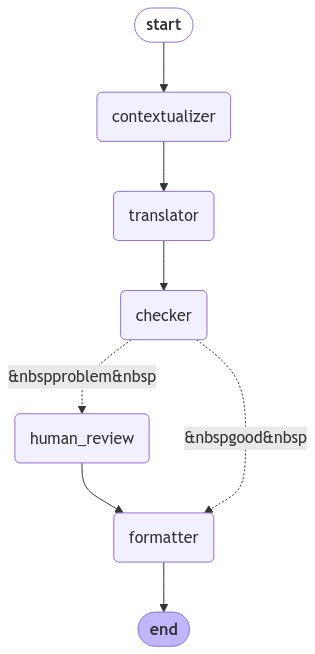

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
state = State(
  messages=[],
  contextualized="",
  translation="",
  advice=""
)
thread = {"configurable": {"thread_id": "1"}}
# response = app.invoke(state, thread)
for output in app.stream(state, thread, stream_mode="updates"):
    print(output)

2024-09-12 16:38:57,759 - INFO - contextualizing
2024-09-12 16:39:02,139 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-12 16:39:02,171 - INFO - translating


{'contextualizer': {'messages': [AIMessage(content='```yaml\n# Title of the dialog box asking a question\ntitle: Question\n\n# Message asking the user if they want to save the puppy\nmessage: Would you like to save the puppy?\n\n# Text for the button that discards the changes or action\nnegative_button: Discard\n\n# Text for the button that saves the changes or action\npositive_button: Save\n```', response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 532, 'total_tokens': 609}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_992d1ea92d', 'finish_reason': 'stop', 'logprobs': None}, id='run-375c4f79-1708-4db1-88cc-dbb18b7bc4eb-0', usage_metadata={'input_tokens': 532, 'output_tokens': 77, 'total_tokens': 609})], 'contextualized': '```yaml\n# Title of the dialog box asking a question\ntitle: Question\n\n# Message asking the user if they want to save the puppy\nmessage: Would you like to save the puppy?\n\n# Text for the button that discards the changes or

2024-09-12 16:39:11,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-12 16:39:11,494 - INFO - checking


{'translator': {'messages': [AIMessage(content='```yaml\n# Title of the dialog box asking a question\ntitle: Pregunta\n\n# Message asking the user if they want to save the puppy\nmessage: ¿Te gustaría salvar al cachorro?\n\n# Text for the button that discards the changes or action\nnegative_button: Descartar\n\n# Text for the button that saves the changes or action\npositive_button: Guardar\n```', response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 140, 'total_tokens': 219}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-18f8eaa3-ef27-4f43-8ea4-0b005ec1f8af-0', usage_metadata={'input_tokens': 140, 'output_tokens': 79, 'total_tokens': 219})], 'translation': '```yaml\n# Title of the dialog box asking a question\ntitle: Pregunta\n\n# Message asking the user if they want to save the puppy\nmessage: ¿Te gustaría salvar al cachorro?\n\n# Text for the button that discards the changes or act

2024-09-12 16:39:13,413 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-12 16:39:13,425 - INFO - translation: 
```yaml
# Title of the dialog box asking a question
title: Pregunta

# Message asking the user if they want to save the puppy
message: ¿Te gustaría salvar al cachorro?

# Text for the button that discards the changes or action
negative_button: Descartar

# Text for the button that saves the changes or action
positive_button: Guardar
```

2024-09-12 16:39:13,427 - INFO - advice: The translation for the positive button, "Guardar," might be misleading in this context. "Guardar" typically means "to save" in the sense of storing or keeping data, which is more commonly used in applications related to files or settings. Since the context here is about saving a puppy, a more appropriate translation would be "Salvar," which clearly conveys the idea of rescuing or saving a life. This ensures that the user understands the action involves h

{'checker': {'messages': [AIMessage(content='The translation for the positive button, "Guardar," might be misleading in this context. "Guardar" typically means "to save" in the sense of storing or keeping data, which is more commonly used in applications related to files or settings. Since the context here is about saving a puppy, a more appropriate translation would be "Salvar," which clearly conveys the idea of rescuing or saving a life. This ensures that the user understands the action involves helping a living being rather than performing a data-saving operation.', response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 203, 'total_tokens': 304}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-497a4232-7881-43e5-99df-49f98bfda678-0', usage_metadata={'input_tokens': 203, 'output_tokens': 101, 'total_tokens': 304})], 'advice': 'The translation for the positive button, "Guardar," might 

In [14]:
user_input = input("Update any line the that needs changing: ")

Update any line the that needs changing:  positive_button: Salvar


In [15]:
import re

key = user_input.split(":")[0].strip()
pattern = rf"^{key}:.*$"
translation = app.get_state(thread).values["translation"]
updated = re.sub(pattern, user_input, translation, flags=re.MULTILINE)

app.update_state(thread, {'translation': updated})
result = app.invoke(None, thread)
formatted = app.get_state(thread).values["messages"][-1].content
logging.info(formatted)

2024-09-12 16:40:00,460 - INFO - translation: 
```yaml
# Title of the dialog box asking a question
title: Pregunta

# Message asking the user if they want to save the puppy
message: ¿Te gustaría salvar al cachorro?

# Text for the button that discards the changes or action
negative_button: Descartar

# Text for the button that saves the changes or action
positive_button: Salvar
```

2024-09-12 16:40:00,467 - INFO - advice: The translation for the positive button, "Guardar," might be misleading in this context. "Guardar" typically means "to save" in the sense of storing or keeping data, which is more commonly used in applications related to files or settings. Since the context here is about saving a puppy, a more appropriate translation would be "Salvar," which clearly conveys the idea of rescuing or saving a life. This ensures that the user understands the action involves helping a living being rather than performing a data-saving operation.
2024-09-12 16:40:00,527 - INFO - formatting
